중간 기점으로 위는 dt 먼저, 아래는 seq 먼저 조절

In [15]:
import numpy as np
from math import *
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
# dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
        print("Dimensions of two states do not match.")
        return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

values = np.arange(1.80, 6.01, 0.01)
# 반올림하여 2자리 소수점까지만 표시
dt_values = [round(val, 2) for val in values]

unitary_choiceList = {}

for dt in dt_values:
    unitary_choiceList[dt] = [unitary(dt, i) for i in range(5)]


init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(rho, dt, predicted_seq):

    # predicted_seq = np.argmax(predicted_seq, axis=-1)
    # if type(predicted_seq) != list:
    #     predicted_seq = np.argmax(predicted_seq, axis=-1).astype(int).tolist()
    
    Uni = s0
    
    for i in predicted_seq:
        Uni = unitary_choiceList[dt][i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final, rho))
    
    return  F

In [16]:
# def rho_making(dt, predicted_comb):
     
#     # rho = np.matrix(irho_init)
#     rho = irho_init
    
#     for i in predicted_comb:
#         instant_U = unitary_choiceList[dt][i]
#         rho = (instant_U @ rho @ instant_U.conj().T)
     
#     return rho


def find_best_dt(seq):
     
    global input_rho
     
    my_dt = 0
    fid = 0         # final fidelity
    i_fid = 0       # temp fidelity
    
    for i in dt_values:
        
        # irho_new = rho_making(i, seq)
        # i_fid = state_fidelity(irho_new, input_rho)
        i_fid = fidelity(input_rho, i, seq)
    
        if fid < i_fid:
            my_dt = i
            fid = i_fid
    
    return my_dt

In [17]:
from itertools import product

def find_best_seq(seq, order, input_dt):
     
     global input_rho
     
     final_seq = []
     temp_seq = []
     temp_fid = 0
     temp_dt = input_dt
     
     # for i in range(-1, -(len(seq)+1), -1):
     for i in range(-1, -9, -1):
          
          if i < -len(seq):
               break
          
          front_seq = seq[:i]
          back_seq = seq[i:]
          
          for combination in product(range(5), repeat=len(back_seq)):
               temp_seq = front_seq + list(combination)
               
               fid = fidelity(input_rho, temp_dt, temp_seq) 
               
               if fid > 0.999901:
                    final_seq = temp_seq
                    print("   && after seq check, over 0.9999 -> No dt check &&", end='\n')
                    return temp_dt, final_seq
               elif fid > temp_fid:
                    final_seq = temp_seq
                    temp_fid = fid

               # print("=============================")
               # print(seq)
               # print(temp_seq)
               # print(final_seq)
               # print("=============================")

     # order == True : seq -> dt
     # order == False : dt -> seq (-> dt)
     if order == False:
          final_dt = temp_dt
          print("   ## before seq check, under 0.9999 -> Need seq check ##", end='\n')
     else:
          final_dt = find_best_dt(final_seq)
          print("   $$ after seq check, under 0.9999 -> dt checked $$", end='\n')
     
     return final_dt, final_seq

In [18]:
import time

def local_optimizer(input_rho, input_seq, check_order, input_dt = 2.6):
     
     first_fid = fidelity(input_rho, input_dt, input_seq)        # default dt=2.6

     if first_fid > 0.999901:
          output_seq = input_seq
          output_dt = input_dt
          computing_t = 0
          print("   ** input data is already over 0.9999 **", end='\n')
     else:        
          start_time = time.time()
          
          output_dt, output_seq = find_best_seq(input_seq, check_order, input_dt)
          
          end_time = time.time()
          computing_t = end_time - start_time

     last_fid = fidelity(input_rho, output_dt, output_seq)

     total_t = output_dt * len(output_seq)
     
     return output_dt, output_seq, first_fid, last_fid, total_t, computing_t

In [19]:
import os
from datetime import datetime
import pandas as pd

# Create a directory to store the results
dir = 'LO_results_dir'
if not os.path.exists(dir):
    os.makedirs(dir)

# CSV file name setup
date = datetime.now()
printdate = date.strftime('%Y%m%d_%H%M%S')
# filename = "/ByLO_dt_" + str(dt) + "_" + printdate + '.csv'
filename = "/ByLO_dt_" + "change_" + printdate + '.csv'

# Create an empty DataFrame and write to CSV file
saved_df = pd.DataFrame(columns=["Case", 'gate length', 'Theta', 'Phi', 'dt', 'combination', 'fidelity',
                           'total time', 'computing time'])
saved_df.to_csv(dir + filename, index=False)

In [20]:
import pandas as pd

df = pd.read_csv('../Data/using/dt_2.6/ByAstar_dt_2.6_1016.csv')
df = df[df['combination'] != '[]']
df = df.drop('Case', axis=1)
df_shuffled = df.sample(frac=1).reset_index(drop=True)

thetas = df_shuffled['Theta'][:100]
phis = df_shuffled['Phi'][:100]
lists = df_shuffled['combination'][:100]

df_shuffled.head()

,gate length,Theta,Phi,dt,combination,total time,computing time
0,25,2.406981,0.171831,2.6,"[1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, ...",65.0,1123.127489
1,26,2.476343,1.336995,2.6,"[1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, ...",67.6,17.939724
2,18,1.698992,2.419211,2.6,"[3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, ...",46.8,14.662599
3,18,1.631560,6.054421,2.6,"[4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, ...",46.8,15.202744
4,33,2.747777,3.396257,2.6,"[3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, ...",85.8,661.409023


In [21]:
case = 0

for input_theta, input_phi, input_sequence in zip(thetas, phis, lists):  

     target_U = Rz(input_phi) @ Rx(input_theta)
     input_rho = target_U @ irho_init @ target_U.conj().T
     
     input_sequence = eval(input_sequence)
     
     # order == True : seq -> dt
     # order == False : dt -> seq (-> dt)
     if input_theta > np.deg2rad(90):
          output_dt, output_sequence, first_fidelity, last_fidelity, total_time, computing_time = local_optimizer(input_rho, input_sequence, True)
     else:
          input_dt = find_best_dt(input_sequence)
          output_dt, output_sequence, first_fidelity, last_fidelity, total_time, computing_time = local_optimizer(input_rho, input_sequence, False, input_dt)
     
     case += 1
     output = [['case' + str(case), len(output_sequence), input_theta, input_phi, output_dt, output_sequence, 
                    last_fidelity, total_time, computing_time]]
    
     # Create DataFrame and append to CSV file
     saved_df = pd.DataFrame(output, columns=["Case", 'gate length', 'Theta', 'Phi', 'dt', 'combination', 
                                                  'fidelity', 'total time', 'computing time'])
     saved_df.to_csv(dir + filename, mode='a', header=False, index=False)

     # Result output
     print(f"""
     -----------------------------------------------------------------------------------------------------------------------
     theta = {input_theta}
     phi = {input_phi}
     selected_dt : {output_dt}
     input_sequence : {input_sequence}
     first_fidelity : {first_fidelity}
     output_sequence : {output_sequence}
     last_fidelity : {last_fidelity}
     total_time : {total_time}
     computing_time : {computing_time}
     -----------------------------------------------------------------------------------------------------------------------
     """)
     
     print(case, "/", len(df_shuffled))


   $$ after seq check, under 0.9999 -> dt checked $$

     -----------------------------------------------------------------------------------------------------------------------
     theta = 2.406980585
     phi = 0.171831303
     selected_dt : 2.62
     input_sequence : [1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 4]
     first_fidelity : 0.9932369725538106
     output_sequence : [1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 4]
     last_fidelity : 0.9965641165046639
     total_time : 65.5
     computing_time : 1084.040231704712
     -----------------------------------------------------------------------------------------------------------------------
     
1 / 27806
   $$ after seq check, under 0.9999 -> dt checked $$

     -----------------------------------------------------------------------------------------------------------------------
     theta = 2.476343082
     phi = 1.336995215
     selected_dt : 2.6
     input_sequen

In [23]:
import pandas as pd

result_df = pd.read_csv('../Local_Optimizer/LO_results_dir/ByLO_dt_change_20231130_173211.csv')

result_df.head()

,Case,gate length,Theta,Phi,dt,combination,fidelity,total time,computing time
0,case1,25,2.406981,0.171831,2.62,"[1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, ...",0.996564,65.50,1084.040232
1,case2,26,2.476343,1.336995,2.60,"[1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, ...",0.999126,67.60,1319.486858
2,case3,18,1.698992,2.419211,2.61,"[3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 4, 4, 4, 1, ...",0.999156,46.98,1605.466041
3,case4,18,1.631560,6.054421,2.59,"[4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 1, 3, 3, 2, ...",0.999618,46.62,1623.923395
4,case5,33,2.747777,3.396257,2.60,"[3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, ...",0.998228,85.80,1646.425718


In [25]:
result_df['fidelity'].mean()

0.9983309403492211

In [26]:
df2 = result_df[result_df['fidelity'] >= 0.9999]

print(df2['fidelity'].mean())
df2.info()

0.9999544186713605
<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 5 to 98
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Case            34 non-null     object 
 1   gate length     34 non-null     int64  
 2   Theta           34 non-null     float64
 3   Phi             34 non-null     float64
 4   dt              34 non-null     float64
 5   combination     34 non-null     object 
 6   fidelity        34 non-null     float64
 7   total time      34 non-null     float64
 8   computing time  34 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.7+ KB


In [27]:
df3 = result_df[result_df['fidelity'] < 0.9999]

print(df3['fidelity'].mean())
df3.info()

0.9974946030317553
<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 0 to 99
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Case            66 non-null     object 
 1   gate length     66 non-null     int64  
 2   Theta           66 non-null     float64
 3   Phi             66 non-null     float64
 4   dt              66 non-null     float64
 5   combination     66 non-null     object 
 6   fidelity        66 non-null     float64
 7   total time      66 non-null     float64
 8   computing time  66 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 5.2+ KB


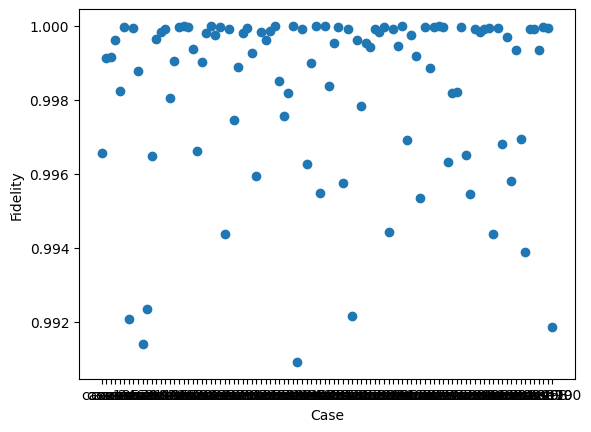

In [29]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(result_df['Case'], result_df['fidelity'], alpha=1)
plt.xlabel('Case')
plt.ylabel('Fidelity')
plt.show()

In [32]:
min(result_df['fidelity'])

0.9909251496728928